In [1]:
import csv
import numpy as np
from matplotlib import pylab as plt
from sklearn.metrics import roc_auc_score, roc_curve, cohen_kappa_score

In [2]:
def read_csv(filename):
    def parse_float(f):
        try:
            return float(f)
        except:
            return f
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)
        data = [[parse_float(f) for f in row] for row in reader]
    return header, data

header_int, data_int = read_csv('combined_results_internal.csv')
header_ext, data_ext = read_csv('combined_results_external.csv')

In [3]:
filenames = [row[0] for row in data_int]
filename_index = {row[0]: row for row in data_int}

bootstrap_samples = [np.random.choice(filenames, size=len(filenames), replace=True) for _ in range(2000)]
bootstrap_rows = [[filename_index[f] for f in sample] for sample in bootstrap_samples]

``` 
majority = [row[header_int.index('majority')] for row in data_int]
patients = {filename[:36] for filename in filenames}
```

In [4]:
def get_auc(rows, reference, observer, class_name):
    i_r = header_int.index(reference)
    i_o = header_int.index(observer)
    ref = [int(row[i_r] == class_name) for row in rows]
    obs = [row[i_o] for row in rows]
    return roc_auc_score(ref, obs)

def auc_scores(reference, class_name, rows, bootstrap_rows):
    result = []
    for obs in ('bespoke_{}'.format(class_name), 'autoML_{}'.format(class_name)):
        score = get_auc(rows, reference, obs, 'normal')
        bootstrapped = [get_auc(rows, reference, obs, 'normal')
                        for rows in bootstrap_rows]
        result.append((score, 
                       np.quantile(bootstrapped, 0.025), 
                       np.quantile(bootstrapped, 0.975))
                     )
    return result

In [5]:
graders = header_int[1:12]
all_aucs = [auc_scores(grader, 'normal', data_int, bootstrap_rows) for grader in graders]

In [6]:
for grader, (bespoke, autoML) in zip(graders, all_aucs):
    print('{:12s} {:.3f} ({:.3f}-{:.3f}) {:.3f} ({:.3f}-{:.3f})'.format(grader, *bespoke, *autoML))

HP           0.982 (0.967-0.994) 0.986 (0.973-0.995)
AMH          0.993 (0.985-0.999) 0.993 (0.984-0.998)
RH           0.972 (0.950-0.988) 0.975 (0.955-0.991)
MA           0.993 (0.985-0.999) 0.989 (0.978-0.997)
JR           0.954 (0.919-0.980) 0.970 (0.939-0.990)
GA           0.980 (0.960-0.994) 0.984 (0.970-0.994)
CH           0.979 (0.959-0.993) 0.976 (0.946-0.995)
JT           0.989 (0.978-0.997) 0.985 (0.971-0.994)
CK           0.955 (0.927-0.979) 0.949 (0.917-0.976)
SB           0.936 (0.901-0.964) 0.935 (0.900-0.963)
majority     0.992 (0.982-0.998) 0.992 (0.983-0.998)


In [7]:
np.mean([bespoke[0] for bespoke, autoML in all_aucs[:-1]]) 

0.9732758273696215

In [8]:
np.mean([autoML[0] for bespoke, autoML in all_aucs[:-1]])

0.9742259928454645

In [9]:
# interpolate false positive rates from 0 to 1 in steps of 0.01
base_fpr = np.linspace(0, 1, 101)

def get_bootstrap_fpr(sample_ref, sample_obs):
    fpr, tpr, threshold = roc_curve(sample_ref, sample_obs)
    return np.interp(base_fpr, fpr, tpr)

In [10]:
def get_roc(rows, reference, observer, class_name, invert):
    i_r = header_int.index(reference)
    i_o = header_int.index(observer)
    ref = [int(row[i_r] == class_name) for row in rows]
    obs = [row[i_o] for row in rows]
    if invert:
        return roc_curve([1 - x for x in ref], [1 - x for x in obs])
    else:
        return roc_curve(ref, obs)

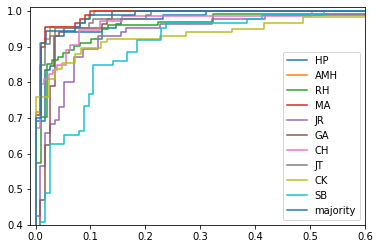

In [11]:
class_name = 'normal'
observer = 'bespoke_{}'.format(class_name)
invert = True
for grader in graders:
    fpr, tpr, threshold = get_roc(data_int, grader, observer, class_name, invert)
    plt.plot(fpr, tpr, label=grader)
plt.xlim(-0.01, 0.6)
plt.ylim(0.4, 1.01)
plt.legend()

In [12]:
graders[:-1]

['HP', 'AMH', 'RH', 'MA', 'JR', 'GA', 'CH', 'JT', 'CK', 'SB']

In [13]:
len(graders[:-1])

10

In [14]:
def se_sp(ref, obs):
    tp = np.sum((ref == 1) & (obs == 1))
    tn = np.sum((ref == 0) & (obs == 0))
    fp = np.sum((ref == 0) & (obs == 1))
    fn = np.sum((ref == 1) & (obs == 0))

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity

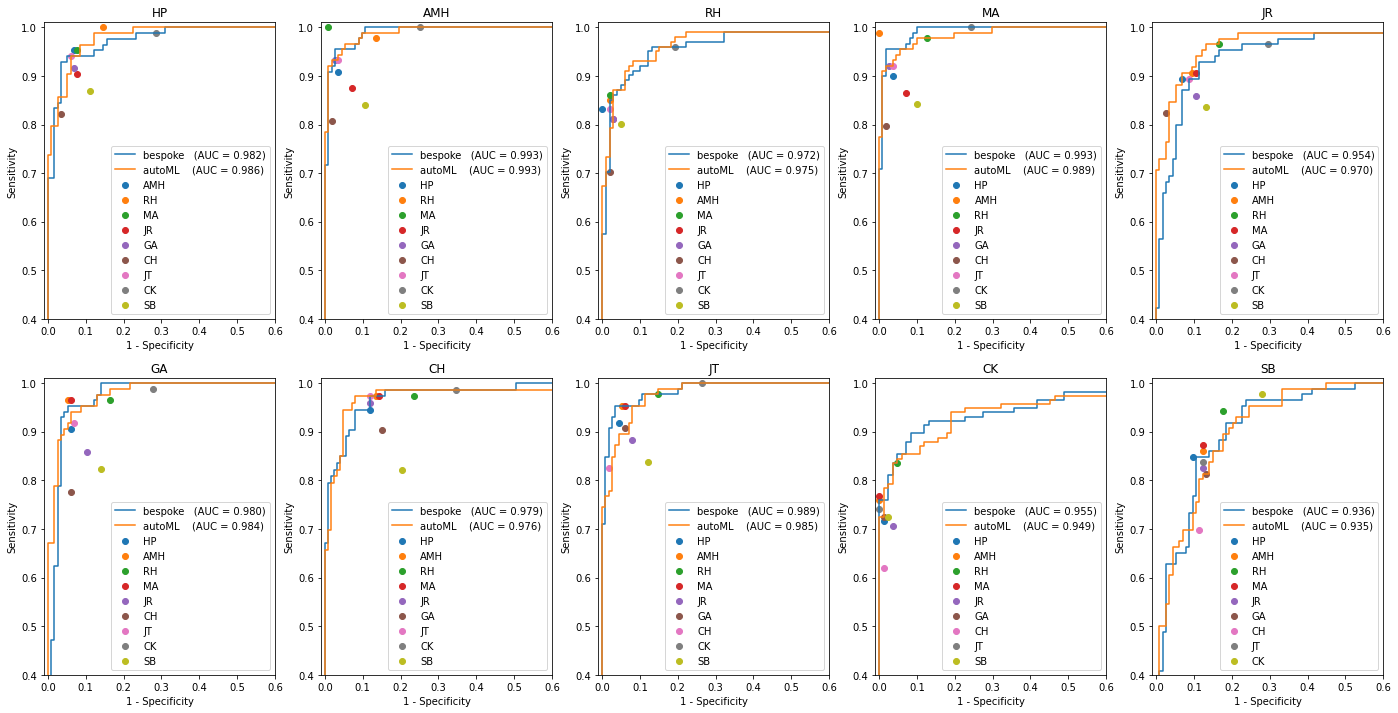

In [15]:
class_name = 'normal'
invert = True

fig, axes = plt.subplots(2, 5, figsize=(24, 12))

for i, grader in enumerate(graders[:10]):
    ax = axes[i//5][i%5]
        
    grader_scores = {
        grader: np.array([int(row[header_int.index(grader)] == class_name) 
                 for row in data_int])
        for grader in graders
    }    
    if invert:
        grader_scores = {g: 1 - ref for g, ref in grader_scores.items()}
    
    ref = grader_scores[grader]    
    
    pts = np.array([se_sp(ref, grader_scores[observer]) 
                    for observer in graders[:10]
                    if observer != grader]
                  )
    labels = [observer for observer in graders[:10] if observer != grader]
    for label, (se, sp) in zip(labels, pts):
        ax.scatter(1 - sp, se, label=label)
        
    for m in 'bespoke', 'autoML':
        model = np.array([row[header_int.index('{}_{}'.format(m, class_name))]
                          for row in data_int])
        if invert:
            model = 1 - model

        fpr, tpr, thresholds = roc_curve(ref, model)    
        auc = roc_auc_score(ref, model)
        ax.plot(fpr, tpr, label = '{:9s} (AUC = {:.3f})'.format(m, auc))
    
    ax.set_xlim(-0.01, 0.6)
    ax.set_ylim(0.4, 1.01)
    ax.set_title(grader)
    ax.legend(loc='lower right')
    ax.set_xlabel('1 - Specificity')
    ax.set_ylabel('Sensitivity')

In [16]:
def plot_confusion(keys, matrix):
    n, n = matrix.shape
    fig = plt.figure(figsize=(15, 12))
    plt.clf()
    ax = fig.add_subplot(111)
    r = ax.imshow(matrix, clim=[0,1], cmap='magma')
    for x in range(n):
        for y in range(n):
            ax.annotate('{:0.2f}'.format(matrix[x][y]), xy=(y, x), 
                        fontsize=12,
                        horizontalalignment='center',
                        verticalalignment='center')
    ax.set_xticks(range(0, n))
    ax.xaxis.tick_top()
    ax.set_yticks(range(n-1, -1, -1))
    ax.set_xticklabels(keys)
    ax.set_yticklabels(keys[::-1])
    ax.set_xlim(-0.5, n-0.5)
    ax.set_ylim(n-0.5, -0.5)
    cb = fig.colorbar(r)

In [17]:
graders_x_axis_ordered = ('majority', 'bespoke', 'autoML', *graders[:10])
kappa_matrix = np.array([[cohen_kappa_score(
            [row[header_int.index(r)] for row in data_int],
            [row[header_int.index(o)] for row in data_int])
  for o in graders_x_axis_ordered
  ]
 for r in graders_x_axis_ordered
])

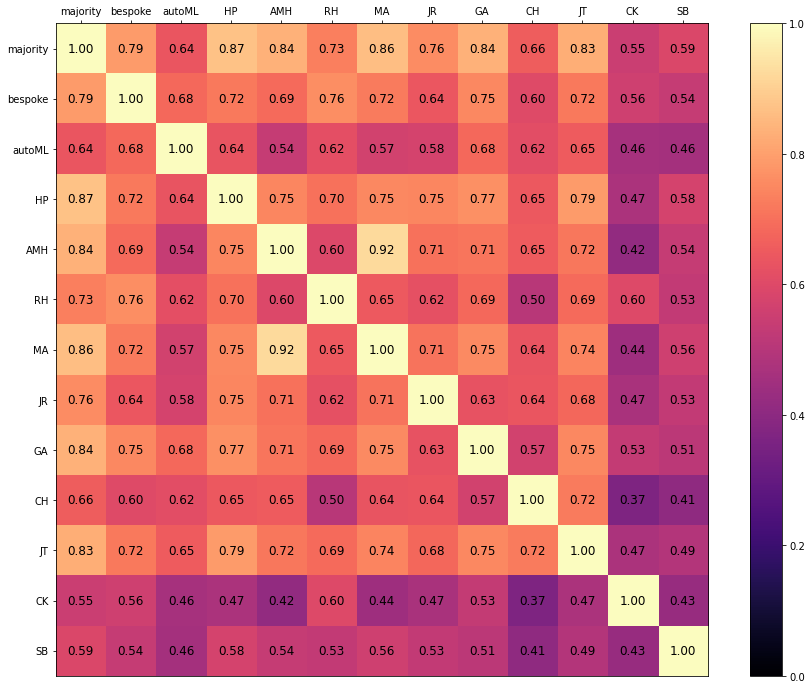

In [18]:
plot_confusion(graders_x_axis_ordered, kappa_matrix)

In [19]:
def get_row(key):
    i = header_int.index(key)
    return np.array([row[i] for row in data_int])

In [20]:
score_index = {
    'normal': 0,
    'pre-plus': 0.5,
    'plus': 1
}

In [21]:
models_disagree = (get_row('autoML') != get_row('majority')) | (get_row('bespoke') != get_row('majority'))

In [22]:
matrix = np.array([
    *[[score_index[x] for x in get_row(grader)]
      for grader in graders_x_axis_ordered
     ],
#    1 - get_row('bespoke_normal'),
#    1 - get_row('autoML_normal'),
 
]).T

In [23]:
order = matrix[models_disagree, :-2].mean(axis=1).argsort()

In [24]:

class_names = 'normal', 'pre-plus','plus'


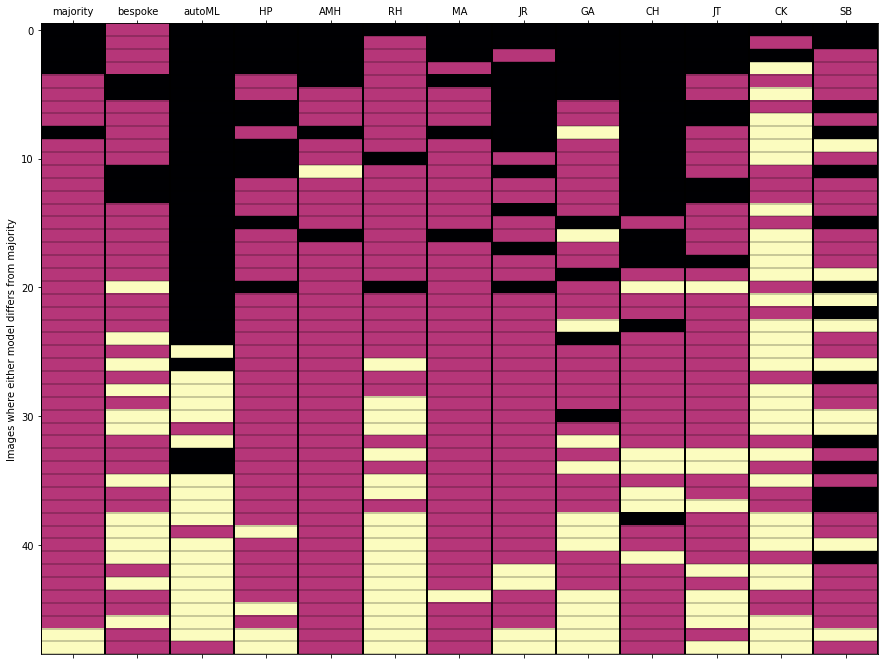

In [25]:
fig = plt.figure(figsize=(15, 12))
ax = fig.gca()
ax.matshow(matrix[models_disagree][order], aspect = 0.2, interpolation='none', cmap='magma') 
#labels = (*graders_x_axis_ordered, 'bespoke', 'autoML')
labels = graders_x_axis_ordered
ax.set_xticks(range(len(labels)))


ax.set_xticks(np.arange(0, len(labels)))

ax.set_xticklabels(labels)

    
for i in range(len(order)+1):
    plt.axhline(i-0.5, c='k', linewidth=2, alpha=0.2)


for i in range(len(labels)+1):
    plt.axvline(i-0.5, c='k', linewidth=2)    
    
plt.ylabel('Images where either model differs from majority')
plt.show()